**Review**

Hi, my name is Dmitry and I will be reviewing your project.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did an excellent job! The project is accepted. Good luck on the next sprint!

# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV,TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor


import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
try:
    taxi_df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')
except:
    taxi_df = pd.read_csv('/datasets/taxi.csv')

In [3]:
def get_info(df):
    print('Head:')
    display(df.head())
    print('--END--')
    print('Info:')
    display(df.info())
    print('--END--')
    print('Missing values:')
    display(df.isnull().sum()/df.shape[0])
    print('--END--')
    print('Duplicates:')
    display(df.duplicated().sum())
    print('--END--')
    print('Describe:')
    display(df.describe())
    
def test_stationarity(df):
    """
        Takes dataframe and test for stationarity.
        Compute the rolling mean for 10 days
        compute the rolling standard deviation for 10days
    """
    rolmean = df['num_orders'].rolling(10).mean()
    rolstd = df['num_orders'].rolling(10).std()
    
    org = plt.plot(df, color = 'blue',label='Original')
    mean = plt.plot(rolmean, color='red', label = 'Rolling mean')
    std = plt.plot(rolstd, color = 'green', label = 'Rolling std')
    plt.legend(loc='best')
    plt.title('Rolling mean and Standard deviation')
    plt.show(block=False)
    
def data_difference(df):
    """
        Takes the dataframe and plots results after analysis
        taxi_diff: computes the series difference
        diff_mean: computes the rolling mean of series difference
        diff_std: computes the rooling std of series difference
    """
    taxi_diff = taxi_df.diff(periods=1)
    diff_mean = taxi_diff.rolling(10).mean()
    diff_std = taxi_diff.rolling(10).std()
    
    org = plt.plot(taxi_diff, color = 'blue',label='Difference')
    mean = plt.plot(diff_mean, color='red', label = 'Diff mean')
    std = plt.plot(diff_std, color = 'green', label = 'Diff std')
    plt.legend(loc='best')
    plt.title('Series Difference: Rolling mean and Standard deviation')
    plt.show(block=False)
    
def decomposed_plot(taxi_df):
    """
        Takes dataframe and plots results after analysis
        decomposition: data is decomposed 
        trend: captures the trend in the data
        seasonal: captures the seasonal variations in data
        residual: captures the residual in the data
    """
    decomposition = seasonal_decompose(taxi_df)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    plt.figure(figsize=(8,8))
    plt.subplot(411)
    plt.plot(taxi_df,label='Original')
    plt.subplot(412)
    plt.plot(trend,label = 'Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonal')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residual')
    plt.legend(loc='Residual')
    plt.tight_layout()

def create_features(df, max_lag,rolling_mean_size):
    """
        Takes the dataframe, number of lagging, 
        and number rolling and returns a new dataframe 
        New features are creatured for year, month, day, dayofmonth, hour, weekend
    """
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['dayofmonth'] = df.index.day
    df['hour'] = df.index.hour
    df['is_weekend'] = df.dayofweek.isin([5,6])*1
    
    for lag in range(1, max_lag +1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return df

def linear_Regression(x_train, x_test, y_train, y_test):
    """
        Takes the training and test dataset
        Scales the data
        Using Linear Regression, the data is trained and predictions made using  
         for both test and training set for their MAE and RMSE
    """
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    lr = LinearRegression().fit(x_train, y_train)
    predict_test = lr.predict(x_test)
    predict_train = lr.predict(x_train)
    print('MAE for train data:',mean_absolute_error(y_train,predict_train ))
    print('MAE for test data:',mean_absolute_error(y_test,predict_test))
    print('RMSE for train data:', mean_squared_error(y_train,predict_train)**0.5)
    print('RMSE for train data:', mean_squared_error(y_test,predict_test)**0.5)
    
def Decision_tree_reg(x_train, x_test, y_train, y_test):
    """
        Takes the training and test dataset
        Using Decision Tree Regression, the data is 
            trained and predictions made using for both 
            test and training set for their MAE and RMSE
    """
    params = {'min_samples_split': range(2,20,2),
             'max_depth': range(2,8,2)}
    tscv = TimeSeriesSplit(n_splits=5)
    grid = GridSearchCV(DecisionTreeRegressor(random_state=123),
                       params, scoring='neg_root_mean_squared_error',
                        cv=tscv, refit=True)
    grid.fit(x_train,y_train)
    dtr = DecisionTreeRegressor(**grid.best_params_).fit(x_train,y_train)
    predict_test = dtr.predict(x_test)
    predict_train = dtr.predict(x_train)
    print('MAE for train data:',mean_absolute_error(y_train,predict_train ))
    print('MAE for test data:',mean_absolute_error(y_test,predict_test))
    print('RMSE for train data:', mean_squared_error(y_train,predict_train)**0.5)
    print('RMSE for train data:', mean_squared_error(y_test,predict_test)**0.5)

def RandomforestReg(x_train, x_test, y_train, y_test):
    """
        Takes the training and test dataset
        Using RandomForest Regression, the data is 
            trained and predictions made using for both 
            test and training set for their MAE and RMSE
    """
    params = {'min_samples_split': range(10, 40, 10), 
              'max_depth': range(4,16,4), 
              'n_estimators':range(50,60,5),
              'max_features':range(3,10,2)}
    tscv = TimeSeriesSplit(n_splits=5)
    grid = GridSearchCV(RandomForestRegressor(),
                        param_grid=params,scoring='neg_root_mean_squared_error', 
                        cv=tscv,n_jobs=5)
    grid.fit(x_train, y_train)
    rfr = RandomForestRegressor(**grid.best_params_).fit(x_train, y_train)
    predict_test = rfr.predict(x_test)
    predict_train = rfr.predict(x_train)
    print('MAE for train data:',mean_absolute_error(y_train,predict_train ))
    print('MAE for test data:',mean_absolute_error(y_test,predict_test))
    print('RMSE for train data:', mean_squared_error(y_train,predict_train)**0.5)
    print('RMSE for train data:', mean_squared_error(y_test,predict_test)**0.5)

def xgboost(x_train, x_test,y_train, y_test):
    """
        Takes the training and test datasets and returns the MAE and RMSE.
        Params: set of parameters to train with 
        grid: Searches through the params and selects the best option
        XGBRegressor is used to train and predict the model
    """
    params = {'max_depth': [4,8],
              'objective':['reg:squarederror'],
              'learning_rate':[0.1]}
    tscv = TimeSeriesSplit(n_splits=5)
    grid = GridSearchCV(XGBRegressor(random_state=123),
                        param_grid=params,
                        scoring='neg_root_mean_squared_error', cv=tscv)
    grid.fit(x_train, y_train)
    xgbr = XGBRegressor(**grid.best_params_)
    xgbr.fit(x_train,y_train,eval_set=[(x_test,y_test)], eval_metric='rmse')
    predict_test = xgbr.predict(x_test)
    predict_train = xgbr.predict(x_train)
    print('MAE for train data:',mean_absolute_error(y_train,predict_train ))
    print('MAE for test data:',mean_absolute_error(y_test,predict_test))
    print('RMSE for train data:', mean_squared_error(y_train,predict_train)**0.5)
    print('RMSE for train data:', mean_squared_error(y_test,predict_test)**0.5)

def Lightgbmreg(x_train,x_test,y_train,y_test):
    """
        Takes the training and test datasets and returns the MAE and RMSE.
        Params: set of parameters to train with 
        grid: Searches through the params and selects the best option
        LGBMRegressor is used to train and predict the model
    """
    params = {'learning_rate': [0.1],
              'max_depth': [6,8],
              'n_estimator':[100,400]}
    tscv = TimeSeriesSplit(n_splits=5)
    g_cv = GridSearchCV(LGBMRegressor(random_state=123),
                        scoring='neg_root_mean_squared_error',
                        param_grid=params, cv=tscv)
    g_cv.fit(x_train, y_train)
    lgbm = LGBMRegressor(**g_cv.best_params_)
    lgbm.fit(x_train,y_train,verbose=1)           
    predict_test = lgbm.predict(x_test)
    predict_train = lgbm.predict(x_train)
    print('MAE for train data:',mean_absolute_error(y_train,predict_train ))
    print('MAE for test data:',mean_absolute_error(y_test,predict_test))
    print('RMSE for train data:', mean_squared_error(y_train,predict_train)**0.5)
    print('RMSE for train data:', mean_squared_error(y_test,predict_test)**0.5)

In [4]:
get_info(taxi_df)

Head:


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


--END--
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


None

--END--
Missing values:


datetime      0.0
num_orders    0.0
dtype: float64

--END--
Duplicates:


0

--END--
Describe:


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


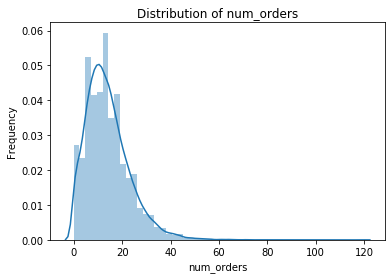

In [5]:
sb.distplot(taxi_df['num_orders'])
plt.title('Distribution of num_orders')
plt.ylabel('Frequency');

In [6]:
taxi_df['datetime'] = pd.to_datetime(taxi_df['datetime'])
taxi_df = taxi_df.set_index('datetime')
taxi_df.index.is_monotonic

True

# Conclusion

There are no missing or null or duplicated values in the dataset. Number of taxi orders column is right skewed with some outliers. 
The datetime column which was string value have been converted to the datetime fomart and column Subsequently  made the index.

<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was loaded and inspected. It's good that you checked that the data is monotonic!

</div>

## Analysis

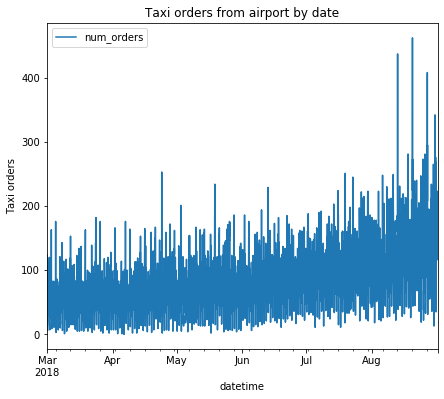

In [7]:
taxi_df.resample('1H').sum().plot(figsize = (7,6),title= 'Taxi orders from airport by date')
plt.ylabel('Taxi orders');

In [8]:
taxi_df = taxi_df.resample('1H').sum()

<div class="alert alert-success">
<b>Reviewer's comment</b>

Resampling is done correctly.

</div>

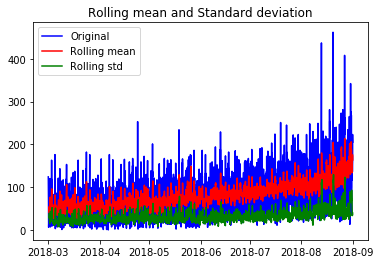

In [9]:
test_stationarity(taxi_df)

The rolling mean of the data rises/varies over time indicating an increasing trend in the data.

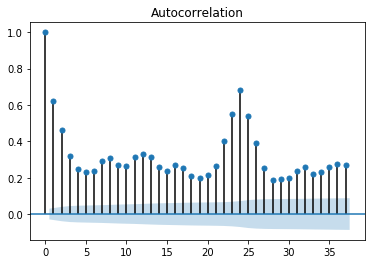

In [10]:
plot_acf(taxi_df)
plt.show()

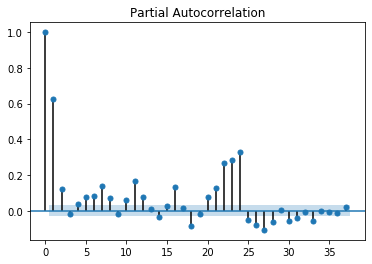

In [11]:
plot_pacf(taxi_df)
plt.show()

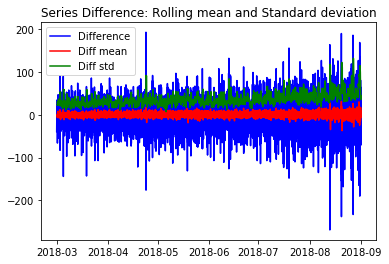

In [12]:
data_difference(taxi_df)

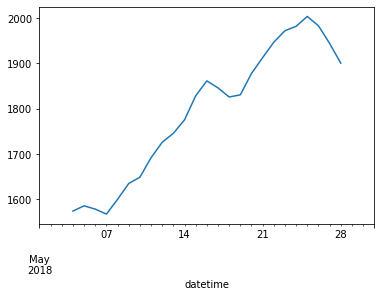

In [13]:
(seasonal_decompose(taxi_df['2018-05-01':'2018-05-31']
                    .resample('1D').sum().loc[:,'num_orders']).trend.plot());

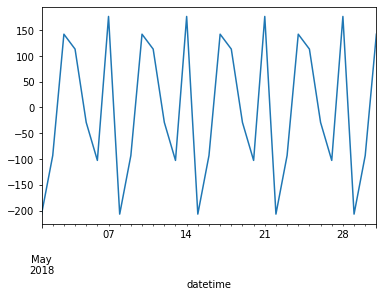

In [14]:
(seasonal_decompose(taxi_df['2018-05-01':'2018-05-31']
                    .resample('1D').sum().loc[:,'num_orders']).seasonal.plot());

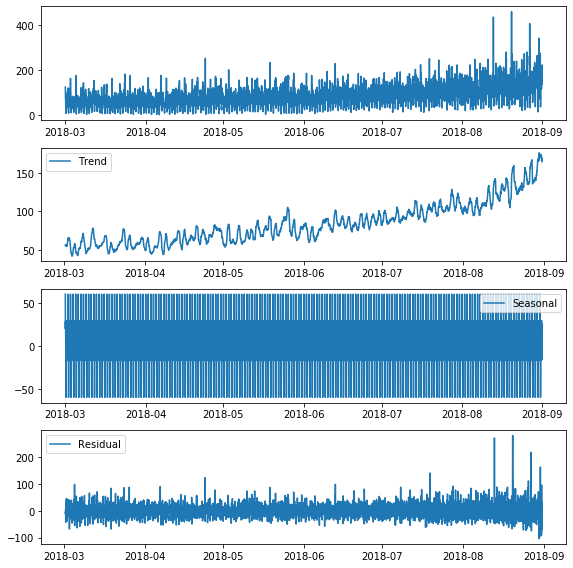

In [15]:
decomposed_plot(taxi_df)

The decomposition of the data shows a repeating pattern in seasonality and an increase in trend over time. 

In [16]:
create_features(taxi_df, 6,10)

,num_orders,year,month,day,dayofweek,dayofmonth,hour,is_weekend,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,1,1,0,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,1,2,0,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,1,3,0,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,1,4,0,66.0,71.0,85.0,124.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4,31,19,0,207.0,217.0,197.0,116.0,133.0,166.0,173.3
2018-08-31 20:00:00,154,2018,8,31,4,31,20,0,136.0,207.0,217.0,197.0,116.0,133.0,166.6
2018-08-31 21:00:00,159,2018,8,31,4,31,21,0,154.0,136.0,207.0,217.0,197.0,116.0,162.9


<div class="alert alert-success">
<b>Reviewer's comment</b>

Feature engineering looks good: you added calendar features, lag features and a correctly shifted rolling mean.

</div>

In [17]:
train,test = train_test_split(taxi_df,shuffle = False, test_size = .1)
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was split into train and test without shuffling, so the models won't cheat

</div>

In [18]:
train = train.dropna()
features_train = train.drop('num_orders',axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders',axis=1)
target_test = test['num_orders']

# Conclusion

The results shows an increasing trend and seasonality in the data. In order to build and trian the model, additional features were created from the datetime coulmn to capture the variations in the data.

## Training & Testing

In [19]:
linear_Regression(features_train, features_test, target_train, target_test)

MAE for train data: 23.406770364489315
MAE for test data: 40.266346781232585
RMSE for train data: 30.472185269351137
RMSE for train data: 53.09117464537393


In [20]:
Decision_tree_reg(features_train, features_test, target_train, target_test)

MAE for train data: 17.92370206004796
MAE for test data: 39.53623888187096
RMSE for train data: 23.57682473201688
RMSE for train data: 53.047521685613866


In [21]:
RandomforestReg(features_train, features_test, target_train, target_test)

MAE for train data: 11.200138590590418
MAE for test data: 34.48313327661838
RMSE for train data: 14.944346586542505
RMSE for train data: 46.50854402987712


In [22]:
xgboost(features_train, features_test, target_train, target_test)

[0]	validation_0-rmse:140.767
[1]	validation_0-rmse:131.101
[2]	validation_0-rmse:123.233
[3]	validation_0-rmse:115.951
[4]	validation_0-rmse:109.504
[5]	validation_0-rmse:103.84
[6]	validation_0-rmse:98.0509
[7]	validation_0-rmse:93.4467
[8]	validation_0-rmse:88.9304
[9]	validation_0-rmse:85.3885
[10]	validation_0-rmse:81.6005
[11]	validation_0-rmse:78.144
[12]	validation_0-rmse:75.1545
[13]	validation_0-rmse:72.7344
[14]	validation_0-rmse:69.9527
[15]	validation_0-rmse:67.9976
[16]	validation_0-rmse:65.9982
[17]	validation_0-rmse:64.5159
[18]	validation_0-rmse:63.0455
[19]	validation_0-rmse:61.633
[20]	validation_0-rmse:60.4718
[21]	validation_0-rmse:59.3904
[22]	validation_0-rmse:58.2086
[23]	validation_0-rmse:57.4742
[24]	validation_0-rmse:56.6844
[25]	validation_0-rmse:55.8007
[26]	validation_0-rmse:54.9834
[27]	validation_0-rmse:54.337
[28]	validation_0-rmse:53.8288
[29]	validation_0-rmse:53.093
[30]	validation_0-rmse:52.3357
[31]	validation_0-rmse:52.0546
[32]	validation_0-rmse:

In [23]:
Lightgbmreg(features_train, features_test, target_train, target_test)

MAE for train data: 11.504206304710374
MAE for test data: 32.00135855338842
RMSE for train data: 15.191170587628548
RMSE for train data: 43.24963893954397


# Model Results
||Model|MAE Train|MAE Test|RMSE Train|RMSE Test|
|--|--|--|--|--|--|
|1|Linear Regression|23.40|40.26|30.47|53.09|
|2|Decision Tree Reg|17.92|39.53|23.57|53.04|
|3|RandomForest Reg|11.33|35.31|15.31|46.50|
|4|XGBoost|14.04|35.24|18.25|46.94|
|5|Light GBM|11.50|32.00|15.19|43.24|


Previous analysis showed that, the data was not stationary subsequently the model was trained uing different models. The best results on RMSE test set came from **RandomForest 46.50, XGBoost  46.94 and LightGBM 43.24.**

<div class="alert alert-success">
<b>Reviewer's comment</b>

Excellent! You trained a few different models, tuned their hyperparameters using cross-validation with an appropriate split for time series and evaluated the final models on the test set. The results look good.

</div>

# Review checklist

- [x]  Jupyter Notebook is open
- [x]  The code is error-free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The data has been analyzed
- [x]  The model has been trained and hyperparameters have been selected
- [x]  The models have been evaluated. Conclusion has been provided
- [x] *RMSE* for the test set is not more than 48